#### An attempt to solve the bulldozers dataset in Kaggle using Random Forests

In [1]:
#Importing requisite libraries
import pandas as pd,numpy as np,re,datetime,os,math,csv
from IPython.display import display
from pandas.api.types import  is_string_dtype,is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.ensemble import forest

##### PARAMETERS EXPLANATION
*Setting Low_memory to prevent memory crunch in guessing the datatype

*Parse date converts string date to a date format from (11/16/2006 0:00) to (2006-11-16)

In [ ]:
# Reading the data
df_raw = pd.read_csv('data/train.csv',low_memory=False ,parse_dates=['saledate'])

In [ ]:
#Checking the size of the dataset and the number of columns
print (df_raw.shape)
display(df_raw.describe(include='all').transpose())

In [ ]:
#EVALUATION METRIC - RMSLE - root mean squared Log error
#Taking the log of the dependent variable
df_raw.SalePrice  = np.log(df_raw.SalePrice)                

In [ ]:
#Converting the date field to various fields <saledate >
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):  
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)


In [ ]:
add_datepart(df_raw,'saledate')

In [ ]:
#Converting categorical variables to numbers
def conv_to_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [ ]:
print (df_raw.head(5)['UsageBand'])

In [ ]:
conv_to_cats(df_raw)
print (df_raw.head(5)['UsageBand'])

In [ ]:
#setting the order for the categories
display(df_raw.UsageBand.cat.categories)



In [ ]:
df_raw.UsageBand.cat.set_categories(['High','Medium','Low'],ordered = True,inplace = True)
df_raw.UsageBand = df_raw.UsageBand.cat.codes

In [ ]:
print (df_raw.head(5)['UsageBand'])

In [ ]:
#Percentage of values which are null
display(df_raw.isnull().sum().sort_index()/len(df_raw))

In [ ]:
#Saving all the precproceesing work in a feather file for later access

os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

#### START FROM HERE - PREPROCESSED

In [2]:
Working_df = pd.read_feather('tmp/bulldozers-raw')

In [3]:
#Splitting into numeric and non numeric data types
quantitative = [f for f in Working_df.columns if is_numeric_dtype(Working_df[f])]
qualitative = Working_df.columns.difference(quantitative)
#Do not replace and Id column and the dependent variable
quantitative.remove('SalesID')
quantitative.remove('SalePrice')


##### REPLACE MISSING VALUES OF NUMERIC DTYPE

In [4]:
#Replace missing values
def fix_missing(df,col):
    if is_numeric_dtype(df[col]):
        df[col+'_na']= pd.isnull(df[col])
        df[col]= df[col].fillna(df[col].median())

In [5]:
for i in quantitative:
    fix_missing(Working_df,i)

##### REPLACE CATEGORICAL VALUES WITH THEIR CODES

In [6]:
#Replace Categorical variable with their codes
def numericalize(df,col):
    if not is_numeric_dtype(df[col]):
        df[col+'_num']= df[col].cat.codes+1


In [7]:
for i in qualitative:
    numericalize(Working_df,i)
    #dropping the categorical column after replacing
    Working_df.drop(i,axis =1,inplace=True)

##### GETTING THE Y VALUE

In [ ]:
y = Working_df.SalePrice

In [ ]:
#calling the Random forest regressor
m = RandomForestRegressor(n_jobs=-1)
m.fit(Working_df, y)
m.score(Working_df, y)


#### Getting a sample of the total data for a better runtime

In [8]:
def get_Sample(df,n): return df.sample(n)
Working_df1 = get_Sample(Working_df,30000)
y1 = Working_df1['SalePrice']
Working_df1.drop('SalePrice',axis=1,inplace=True)


In [13]:
#extracting subset for processing
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [ ]:
#Using splitvals for subsetting

n_valid = 12000  # same as Kaggle's test set size

n_trn = len(Working_df1)-n_valid
raw_train, raw_valid = split_vals(Working_df1, n_trn)
X_train, X_valid = split_vals(Working_df1, n_trn)
y_train, y_valid = split_vals(y1, n_trn)

X_train.shape, y_train.shape, X_valid.shape

#### RMSE

In [9]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())


In [10]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [ ]:
#calling the Random forest regressor
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train,y_train)
print_score(m)

### Trying Subsampling

In [11]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [15]:
validation = 12000
n_trn = len(Working_df)-12000
X_train, X_valid = split_vals(Working_df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [16]:
set_rf_samples(20000)

In [17]:
#Base model with training and validation set
m = RandomForestRegressor(n_jobs=-1,n_estimators=40,max_features=0.5)
m.fit(X_train,y_train)
print_score(m)

[0.008434402269670743, 0.01232167503009248, 0.9998513231172482, 0.9997288638186683]


In [23]:
b=np.stack([i.predict(X_valid) for i in m.estimators_])
#Default is 10 estimators and each estimator produces an array of n values(based on the sampling) (X_train)
#Average of the 10 estimators for each of them would be the output from the random forest model
#For the last record the random forest output would be
b[:,11999],np.mean(b[:,11999]),list(y_valid)[11999]


(array([8.98719682, 8.94897561, 9.15904708, 9.04782144, 9.04782144,
        9.01796848, 8.95544812, 8.9226583 , 8.95544812, 8.94897561,
        8.96187901, 8.9226583 , 8.9226583 , 8.9226583 , 8.9226583 ,
        9.43348392, 8.95544812, 8.95544812, 8.95544812, 8.9226583 ,
        9.04782144, 8.98719682, 8.98719682, 8.95544812, 8.95544812,
        8.98719682, 8.95544812, 8.96187901, 8.98719682, 8.95544812,
        8.61250337, 8.95544812, 8.95544812, 8.95544812, 8.95544812,
        9.10497986, 8.95544812, 8.95544812, 8.9226583 , 8.96187901]),
 8.974533733102252,
 8.955448122347393)

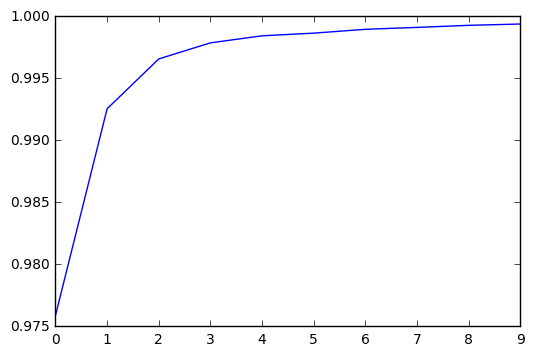

In [21]:
plt.plot([metrics.r2_score(y_valid, np.mean(b[:i+1], axis=0)) for i in range(10)]);

In [ ]:
#Finding the features which are better and retaining only them.
#Plotting the R^2 and the importances on a graph can show us the corelation and the values  of importances above which it matters
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(m.feature_importances_,3)})
keeping = (importances[importances['importance'] > 0.005].sort_values('importance',ascending=False))
trunc_df = Working_df[keeping.feature]
trunc_df.shape

In [ ]:
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(trunc_df)-n_valid
raw_train, raw_valid = split_vals(trunc_df, n_trn)
X_train, X_valid = split_vals(trunc_df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

In [ ]:
##model with truncated features and max_features parameter
m = RandomForestRegressor(n_estimators =40,n_jobs=-1,max_features = 0.5)
m.fit(X_train,y_train)
print_score(m)